In [1]:
import rishi_utils as ru
from rdkit import Chem
import fall20_mse_8803 as retro
import importlib
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
importlib.reload(retro)
importlib.reload(ru)
import numpy as np
import pickle
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 600

Restored variables from /data/rgur/retrosynthesis/scscore/models/full_reaxys_model_1024uint8/model.ckpt-10654.as_numpy.json.gz
Restored variables from /data/rgur/retrosynthesis/scscore/models/full_reaxys_model_1024uint8/model.ckpt-10654.as_numpy.json.gz


# Make ring-closing rxn

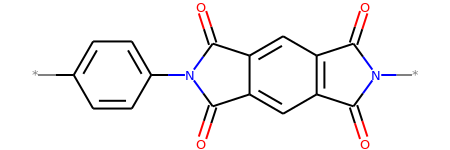

In [13]:
mol = Chem.MolFromSmiles('*c4ccc(n3c(=O)c2cc1c(=O)n(*)c(=O)c1cc2c3=O)cc4')
mol

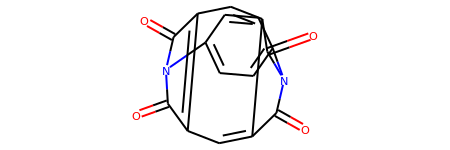

In [14]:
lp = ru.LinearPol(mol)
pm = lp.PeriodicMol()
pm

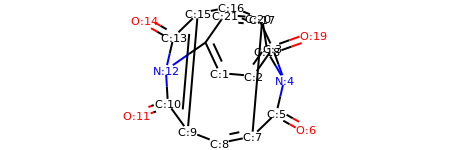

In [19]:
ru.mol_with_atom_index(pm)

In [21]:
pm.GetRingInfo().AtomRings()

((5, 4, 18, 17, 7),
 (10, 9, 15, 13, 12),
 (1, 2, 3, 20, 21, 0),
 (8, 9, 15, 16, 17, 7),
 (1, 0, 12, 10, 9, 8, 7, 5, 4, 3, 2))

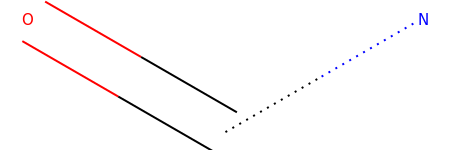

In [23]:
start_match = Chem.MolFromSmarts('[cR](=O)[nR]') #the ring we want to break
start_match

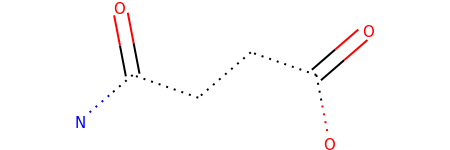

In [16]:
end_match = Chem.MolFromSmarts('[CR0](=O)([OH])CC[CR0](=O)[NR0]') #the group we want to end up with
end_match

In [24]:
Chem.GetSSSR(pm)
pm.HasSubstructMatch(start_match) #should be True

True